# Runge-Kutta integration for multiple coupled variables

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [15]:
def dydx(x,y):
    #set the derivatives
    
    #our equation is d^2y/dx^2 = -y
    
    #so we can write
    #dydx = z
    #dzdx = -y
    
    #we will set y = y[0]
    #we will set z = y[1]
    
    #declare an array
    y_derivs = np.zeros(2)
    
    #set dydx = z
    y_derivs[0] = y[1]
    #set dzdx = -y
    y_derivs[1] = -1*y[0]
    
    return y_derivs

## Define 6th order RK

In [16]:
def rk6_mv_core(dydx,xi,yi,nv,h):
    
    #declare k? arrays
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    k5 = np.zeros(nv)
    k6 = np.zeros(nv)
   
    #declare a temp y array
    y_temp = np.zeros(nv)
    
    #get k1 values
    y_derivs = dydx(xi,yi)
    k1[:] = h*y_derivs[:]
    
    #get k2 values
    y_temp[:] = yi[:] + 1/5*k1[:]
    y_derivs = dydx(xi+1/5*h,y_temp)
    k2[:] = h*y_derivs[:]
    
    #get k3 values
    y_temp[:] = yi[:] + 3/40*k1[:] + 9/40*k2[:]
    y_derivs = dydx(xi+3/10*h,y_temp)
    k3[:] = h*y_derivs[:]
    
    #get k4 values
    y_temp[:] = yi[:] + 3/10*k1[:] + (-9/10)*k2[:] + 6/5*k3[:]
    y_derivs = dydx(xi+3/5*h,y_temp)
    k4[:] = h*y_derivs[:]
    
    #get k5 values
    y_temp[:] = yi[:] +(-11/54)*k1[:] + 5/2*k2[:] + (-70/27)*k3[:] + 35/27*k4[:]
    y_derivs = dydx(xi+h,y_temp)
    k5[:] = h*y_derivs[:]
    
    #get k6 values
    y_temp[:] = yi[:] + 1631/55296*k1[:] + 175/512*k2[:] + 575/13824*k3[:] + 44275/110592*k4[:] + 253/4096*k5[:]
    y_derivs = dydx(xi+7/8*h,y_temp)
    k6[:] = h*y_derivs[:]
    
    #advance y by a step h
    yipo = yi + 37/378*k1 + 250/621*k3 + 125/594*k4 + 512/1771*k6 + h**6
    
    return yipo

## Define an adaptive step size driver for RK6



In [17]:
def rk6_mv_ad(dydx,x_i,y_i,nv,h,tol):
    #define safety scale
    SAFETY = 0.9
    H_NEW_FAC = 2.0
    
    #set a maximum number of iterations
    imax = 10000
    #set an iteration variable
    i=0
    
    #create an error
    Delta = np.full(nv,2*tol)
    #remember the step
    h_step = h
    #adjust step
    while(Delta.max()/tol > 1.0):
        #estimate our error by taking one step of size h
        #vs. two steps of size h/2
        y_2 = rk6_mv_core(dydx,x_i,y_i,nv,h_step)
        y_1 = rk6_mv_core(dydx,x_i,y_i,nv,0.5*h_step)
        y_11 = rk6_mv_core(dydx,x_i +0.5*h_step,y_1,nv,0.5*h_step)
        
        #compute an error
        Delta = np.fabs(y_2 - y_11)
        #if the error is too large, take a smaller step
        if(Delta.max()/tol>1.0):
            
            #our error is too large, devrease the step
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
            
        #check iteration
        if(i>=imax):
            print("Too many iterations in rk6_mv_ad()")
            raise StopIteration("Ending after i = ", i)
            
        #iterate
        i+=1
        
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    return y_2, h_new, h_step
            
            

## Define a wrapper for RK6

In [18]:
def rk6_mv(dfdx,a,b,y_a,tol):
    
    #dfdx is the derivative wrt x
    #a is the lower bound
    #b is the upper bound
    #y_a are the boundary conditions
    #tol is the tolerance for integrating y
    
    #define our starting step
    xi=a
    yi=y_a.copy()
    
    h = 1.0e-4 *(b-a)
    imax=10000
    i = 0
    nv = len(y_a)
    x = np.full(1,a)
    y = np.full((1,nv),y_a)
    
    flag = 1
    
    while(flag):
        yi_new, h_new, h_step = rk6_mv_ad(dydx,xi,yi,nv,h,tol)
        h= h_new
        
        if(xi+h_step>b):
            
            h = b-xi
            yi_new, h_new, h_step = rk6_mv_ad(dydx,xi,yi,nv,h,tol)
            
            flag = 0
            
            xi += h_step
            yi[:] = yi_new[:]
            
            x = np.append(x,xi)
            y_new = np.zeros((len(x),nv))
            y_new[0:len(x)-1,:] = y
            y_new[-1,:] = yi[:]
            del y
            y = y_new
            
            if(i>=imax):
                
                print("Maximum iterations reached.")
                raise StopIteration("Iteration number = ",i)
                
            i += 1
            
            s = "i = %3d\tx = %9.8f\th = %9.8f\tb=%9.8f" % (i,xi, h_step,b)
            print(s)
            
            if(xi==b):
                flag = 0
        return x,y


In [19]:
a = 0.0
b = 2.0 *np.pi

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

x,y = rk6_mv(dydx,a,b,y_0,tolerance)

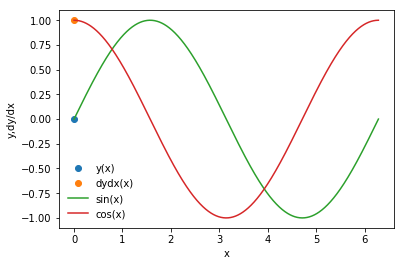

In [20]:
plt.plot(x,y[:,0],'o',label='y(x)')
plt.plot(x,y[:,1],'o',label='dydx(x)')
xx = np.linspace(0,2.0*np.pi,1000)
plt.plot(xx,np.sin(xx),label='sin(x)')
plt.plot(xx,np.cos(xx),label='cos(x)')
plt.xlabel('x')
plt.ylabel('y,dy/dx')
plt.legend(frameon=False)

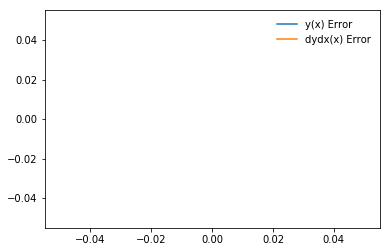

In [21]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0]-sine)
dydx_error = (y[:,1]-cosine)

plt.plot(x,y_error,label="y(x) Error")
plt.plot(x,dydx_error,label="dydx(x) Error")
plt.legend(frameon=False)